<a href="https://colab.research.google.com/github/Saaiheswar/Neural-Style-Transfer/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
#Importing the Packages

from PIL import Image
import time
import tensorflow as tf
import numpy as np

from tensorflow.keras import backend
#from tf.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
#from scipy.misc import imsave

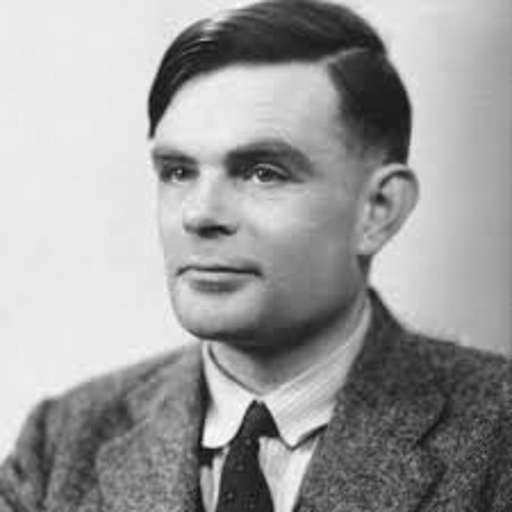

In [131]:
height = 512
width = 512

content_image_path = '/alan.png.jpeg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width,height))
content_image

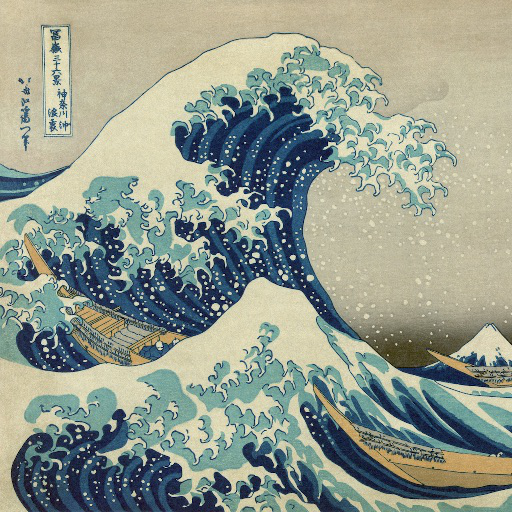

In [113]:
style_image_path = '/output_4_0.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width,height))
style_image

In [114]:
#converting the content and style into array
content_array = np.asarray(content_image, dtype='float32')
print(content_array.shape)
content_array = np.expand_dims(content_array,axis=0)
#After adding Dimension
print(content_array.shape)

style_array = np.asarray(style_image,dtype = 'float32')
print(style_array.shape)
style_array = np.expand_dims(style_array,axis=0)
#After addind Dimension
print(style_array.shape)

(512, 512, 3)
(1, 512, 512, 3)
(512, 512, 3)
(1, 512, 512, 3)


In [115]:
#Subtract the mean RGB value 
content_array[:,:,:,0] -= 103.939
content_array[:,:,:,1] -= 116.779
content_array[:,:,:,2] -= 123.68
#Flip the ordering of the multi-dimensional array from RGB to BGR 
content_array = content_array[:,:,:,::-1]

#Subtract the mean RGB value 
style_array[:,:,:,0] -= 103.939
style_array[:,:,:,1] -= 116.779
style_array[:,:,:,2] -= 123.68
#Flip the ordering of the multi-dimensional array from RGB to BGR
style_array = style_array[:,:,:,::-1]

In [116]:
#Initialise the content image,style image and make Combinational Image
tf.keras.backend.clear_session()
content_image = tf.keras.backend.variable(content_array)
style_image = tf.keras.backend.variable(style_array)
combination_image = tf.keras.backend.placeholder((1,height,width,3))


In [117]:
#Concatenate to send them as Input tensor
input_tensor = tf.keras.backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [118]:
#Instantiate VGG16 
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

In [119]:

layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

In [120]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0
loss = tf.keras.backend.variable(0.)

In [121]:
#The content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images.
def content_loss(content, combination):
    return tf.keras.backend.sum(tf.keras.backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = loss + (content_weight * content_loss(content_image_features,
                                      combination_features))

In [122]:
#Make Gram matrix to calculate covariance
def gram_matrix(x):
    features = tf.keras.backend.batch_flatten(tf.keras.backend.permute_dimensions(x, (2, 0, 1)))
    gram = tf.keras.backend.dot(features, backend.transpose(features))
    return gram

In [124]:
#calculating style loss
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return tf.keras.backend.sum(tf.keras.backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [125]:
#variation loss for regularisation
def total_variation_loss(x):
    a = tf.keras.backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = tf.keras.backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [126]:
#disable eager execution or else it will give error while using bac
tf.compat.v1.disable_eager_execution()
grads = tf.keras.backend.gradients(loss, combination_image)

In [127]:
outputs = [loss]
outputs += grads
f_outputs = tf.keras.backend.function([combination_image], outputs)
#Evaluator class that computes loss and gradients in one pass while
#retrieving them via two separate functions, loss and grads.
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [128]:
#we use the L-BFGS algorithm (a quasi-Newton algorithm that's significantly 
#quicker to converge than standard gradient descent) to iteratively improve upon it.
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 81864980000.0
Iteration 0 completed in 6s
Start of iteration 1
Current loss value: 58738710000.0
Iteration 1 completed in 6s
Start of iteration 2
Current loss value: 48705650000.0
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 45066940000.0
Iteration 3 completed in 6s
Start of iteration 4
Current loss value: 43434500000.0
Iteration 4 completed in 6s
Start of iteration 5
Current loss value: 42462077000.0
Iteration 5 completed in 6s
Start of iteration 6
Current loss value: 41932927000.0
Iteration 6 completed in 6s
Start of iteration 7
Current loss value: 41591410000.0
Iteration 7 completed in 6s
Start of iteration 8
Current loss value: 41366920000.0
Iteration 8 completed in 6s
Start of iteration 9
Current loss value: 41227866000.0
Iteration 9 completed in 6s


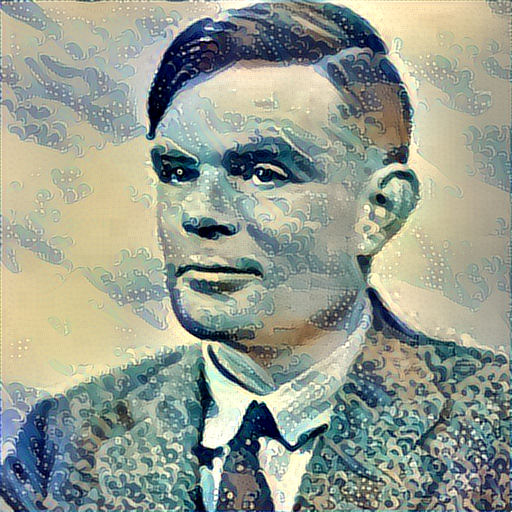

In [129]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)